In [142]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, QuantumRegister, AncillaRegister
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector

In [143]:
#parameters

n = 4 # qubits

w1 = 0.5 ##diffusion
w2 = 0.5 ##diffusion
e1 = 1   ##right
e2 = -1  ##left
cs = 1   ##speed of sound
u = 0.2  ##advection 

In [147]:
def oneStep(n,w1,w2,e1,e2,cs,u):
    #initializing
    x = w1*(1+e1*u/cs**2)
    y = w2*(1+e2*u/cs**2)
    
    lambda1 = np.round(np.log(complex(x, np.sqrt(1-x**2))), 10)
    lambda2 = np.round(np.log(complex(y, np.sqrt(1-y**2))), 10)
    

    q = QuantumRegister(n,'q')
    a = AncillaRegister(1,'a')

    qc = QuantumCircuit(q)
    qc.add_register(a)
     
    qc.barrier()
    
    
    #collisions
    def createC(lambda1, lambda2, isC1 = True):
    
        if not isC1:
            lambda1=np.conj(lambda1)
            lambda2=np.conj(lambda2)

        lambda1=lambda1.imag
        lambda2=lambda2.imag

        qc=QuantumCircuit(2)

        #phase1 -> x -> phase1 -> x -----ctrl=0
        qc.cp(lambda1, 0 ,1 , ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)
        qc.cp(lambda1, 0, 1, ctrl_state = 0)
        qc.cx(0, 1, ctrl_state = 0)

        #phase2 -> x -> phase2 -> x -----ctrl=1 is default
        qc.cp(lambda2, 0, 1)
        qc.cx(0, 1)
        qc.cp(lambda2, 0, 1)
        qc.cx(0, 1)

        return qc
    
    C1 = createC(lambda1, lambda2, True)
    c1gate = C1.to_gate(label = 'c1')
    C2 = createC(lambda1, lambda2, False)
    c2gate = C2.to_gate(label = 'c2')
    
    ######adding steps to circuit
    qc.h(a)
    
    ##c1 and c2 act on every qubit controlled on ancilla
    for i in range(n):
        qc.append(c1gate,[a,i])
    for i in range(n):
        qc.append(c2gate,[a,i])

    qc.h(a)
    qc.draw()
    
    
    
    #propagation
    def rshift(n):
        circ = QuantumCircuit(n)
        for i in range(n):
            if i == n-1:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n)), i)
        return circ

    def lshift(n):
        circ = QuantumCircuit(n)
        for i in reversed(range(n)):
            if i == n-1:
                circ.x(i)
            else:
                circ.mcx(list(range(i+1,n)), i)
        return circ

    R = rshift(n).to_gate(label = "R").control(1, ctrl_state = 0)
    L = lshift(n).to_gate(label = "L").control(1, ctrl_state = 1)
    
    cbits = [a]
    cbits.extend([i for i in range(n)])  #### could also be [i for i in range(n-1,-1,-1)]

    qc.append(R,cbits)
    qc.append(L,cbits)

    
    ########################## macros
    qc.swap(a,n-1)
    qc.h(a)
    #### -> not sure if there is an extra step
    
    return qc

In [148]:
qc = oneStep(n, w1, w2, e1, e2, cs, u)

/var/folders/jp/s01ry41n1ksb327qbnx4y_bh0000gn/T/ipykernel_10793/1420723593.py:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  a+=qc


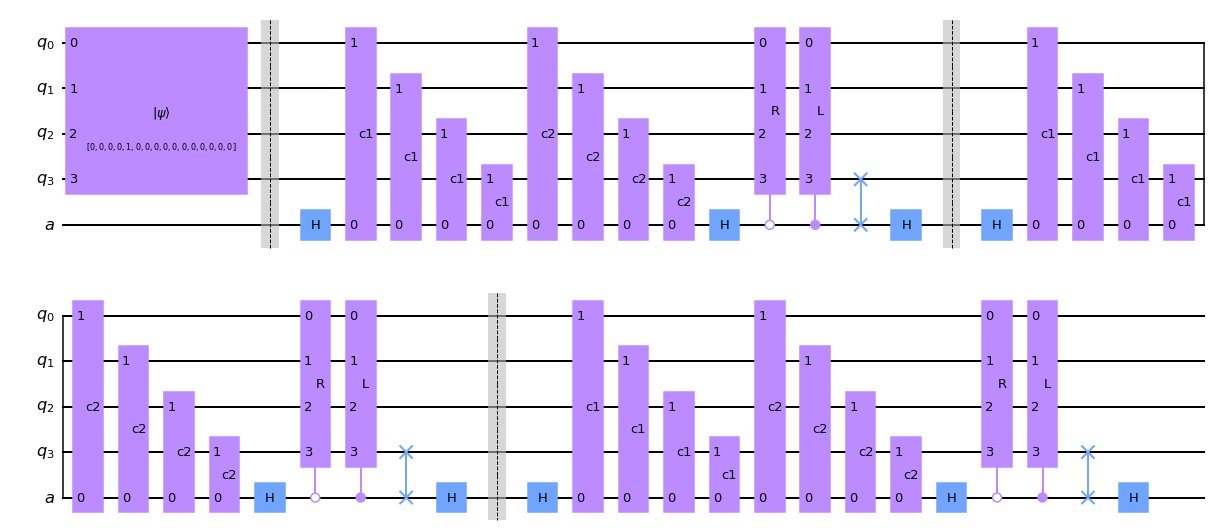

In [149]:
#initial state------> needs some work
classicalState = np.zeros(n**2)
classicalState[4] = 1

#####initialize circuit
a = QuantumCircuit(n)
a.initialize(classicalState)

#### adding t timesteps
t=3
for i in range(t):
    a+=qc
a.draw()

#####need to decipher in the end

In [150]:
#notes-> check hadamards